## Hospedagens em Recife
Buscamos analisar as mudanças sazonais do preço das hospedagens em recife

In [1]:
import pandas as pd
import numpy as np

In [31]:
# carregando o dataset completo
hosp = pd.read_csv('../resultado1.csv', decimal=".")

## Definindo o tipo dos dados

In [32]:
hosp['checkin'] = pd.to_datetime(hosp['checkin'])
hosp['checkout'] = pd.to_datetime(hosp['checkout'])
hosp['cidade'] = hosp["cidade"].astype("category")
hosp['hotel'] = hosp["hotel"].astype("category")
hosp['data_extracao'] = hosp["data_extracao"].astype("category")

In [33]:
# pegando do dataset apenas os dados até junho de 2025 para comparar um ano inteiro sem repetições
hospedagens = hosp[~((hosp['checkin'].dt.month > 6) & (hosp['checkin'].dt.year == 2025))]

In [5]:
# confirmando o tipo dos dados
hospedagens.dtypes

hotel                    category
cidade                   category
preço                       int64
checkin            datetime64[ns]
checkout           datetime64[ns]
dist_centro               float64
dist_praia                float64
avaliacao                 float64
qtnd_avaliacoes           float64
data_extracao            category
dtype: object

## Estatísticas Iniciais

In [6]:
# tamanho dos dados
hospedagens.shape

(15643, 10)

In [7]:
# visualizando as colunas 
hospedagens.columns

Index(['hotel', 'cidade', 'preço', 'checkin', 'checkout', 'dist_centro',
       'dist_praia', 'avaliacao', 'qtnd_avaliacoes', 'data_extracao'],
      dtype='object')

In [8]:
# agrupamos os dados por mês para entender a média dos preços de cada mês
preco_medio_mensal = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].mean()
preco_medio_mensal

C:\Users\extre\AppData\Local\Temp\ipykernel_7744\366261908.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  preco_medio_mensal = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].mean()


checkin
2024-07-31    1853.438967
2024-08-31    1852.081880
2024-09-30    1936.745310
2024-10-31    1977.388763
2024-11-30    2011.614892
2024-12-31    2269.954579
2025-01-31    2461.325480
2025-02-28    2248.170360
2025-03-31    2720.275000
2025-04-30    2325.341146
2025-05-31    2297.971154
2025-06-30    2122.087601
Freq: ME, Name: preço, dtype: float64

In [9]:
# número de acomodações aparecendo por mês
num_hospedagens_mes = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].count()
num_hospedagens_mes

C:\Users\extre\AppData\Local\Temp\ipykernel_7744\3033508448.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  num_hospedagens_mes = hospedagens.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].count()


checkin
2024-07-31    2130
2024-08-31    2064
2024-09-30    1759
2024-10-31    1762
2024-11-30    1719
2024-12-31    1343
2025-01-31    1146
2025-02-28     722
2025-03-31     760
2025-04-30     768
2025-05-31     728
2025-06-30     742
Freq: ME, Name: preço, dtype: int64

In [34]:
# criando uma coluna para armazenar o mês do checkin
# é interessante pois vamos analisar a sazonalidade dos dados
hospedagens['mes_checkin'] = hospedagens['checkin'].dt.month

C:\Users\extre\AppData\Local\Temp\ipykernel_7744\2195187864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospedagens['mes_checkin'] = hospedagens['checkin'].dt.month


In [39]:
# Contar a quantidade de semanas distintas para cada hotel
hotel_week_count = hospedagens.groupby('hotel')['checkin'].nunique()

# Identificar o número máximo de semanas no período (52 semanas em um ano)
max_weeks = hospedagens['checkin'].nunique()

# Identificar os hotéis que aparecem em todas as semanas
hotels_all_weeks = hotel_week_count[hotel_week_count == max_weeks].index

# Filtrar o DataFrame para manter apenas os hotéis que aparecem em todas as semanas
hospedagens_filtered = hospedagens[hospedagens['hotel'].isin(hotels_all_weeks)]
hospedagens_filtered

C:\Users\extre\AppData\Local\Temp\ipykernel_7744\413734298.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hotel_week_count = hospedagens.groupby('hotel')['checkin'].nunique()


,hotel,cidade,preço,checkin,checkout,dist_centro,dist_praia,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin
23,Flat em Boa Viagem,Recife,1190,2024-07-01,2024-07-08,9.4,0.1,7.4,1798.0,2024-6-6,7
24,Casa Recife Pousada,Recife,421,2024-07-01,2024-07-08,8.2,1.1,7.1,602.0,2024-6-6,7
27,Hotel Dan Inn Mar Piedade - Grande Recife,Recife,1953,2024-07-01,2024-07-08,13.7,0.0,7.8,2778.0,2024-6-6,7
33,Marante Plaza Hotel,Recife,3079,2024-07-01,2024-07-08,5.0,0.0,8.3,2420.0,2024-6-6,7
39,Flat em Boa Viagem,Recife,1070,2024-07-01,2024-07-08,9.3,0.1,7.4,461.0,2024-6-6,7
...,...,...,...,...,...,...,...,...,...,...,...
15634,flatpaivahome bugan paiva,Recife,1886,2025-06-22,2025-06-29,19.6,0.7,NaN,NaN,2024-6-6,6
15636,Apto a beira-mar em Jaboatao dos Guararapes PE,Recife,2050,2025-06-22,2025-06-29,19.4,0.6,9.0,2.0,2024-6-6,6
15637,Apt novíssimo Tamarineira,Recife,3780,2025-06-22,2025-06-29,4.1,NaN,10.0,4.0,2024-6-6,6
15638,Hostel da Socorro,Recife,2835,2025-06-22,2025-06-29,9.0,0.9,1.0,1.0,2024-6-6,6


In [48]:
hospedagens_filtered['preço'].median()

1714.0

In [49]:
hospedagens['preço'].median()

1638.0

In [11]:
# calculando o desvio padrão dos preços médios dos meses
preco_medio_mensal['price_change'] = preco_medio_mensal.std()
preco_medio_mensal['price_change']


263.601427112874

<Axes: >

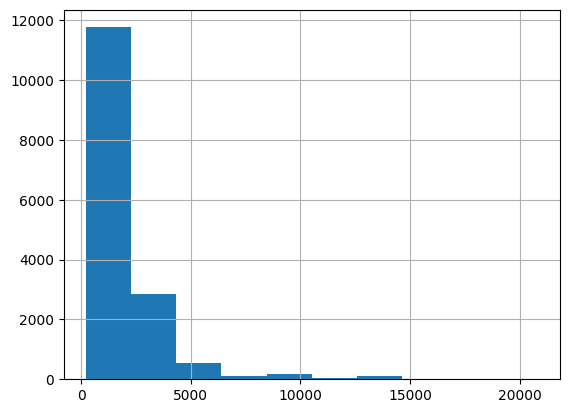

In [ ]:
# hiistograma do preço de estadia por 7 dias
hospedagens['preço'].hist()

## Definindo dados faltantes

In [ ]:
# printando quantas linhas de cada coluna está faltante
print(hospedagens.isnull().sum())

hotel                 0
cidade                0
preço                 0
checkin               0
checkout              0
dist_centro           0
dist_praia         4606
avaliacao          3133
qtnd_avaliacoes    3133
data_extracao         0
mes_checkin           0
log_price             0
dtype: int64


<Axes: >

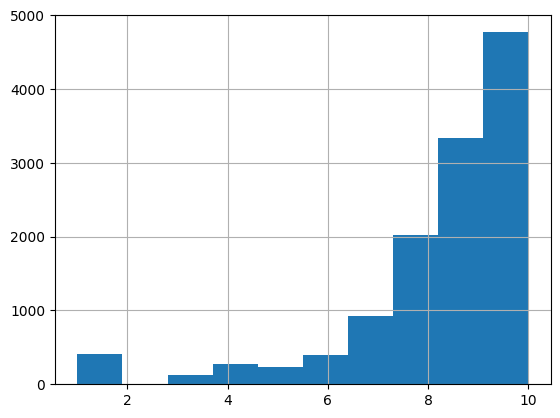

In [ ]:
# vamos plotar histogramas das colunas com dados faltantes para entender as particularidades
hospedagens["avaliacao"].hist()

<Axes: >

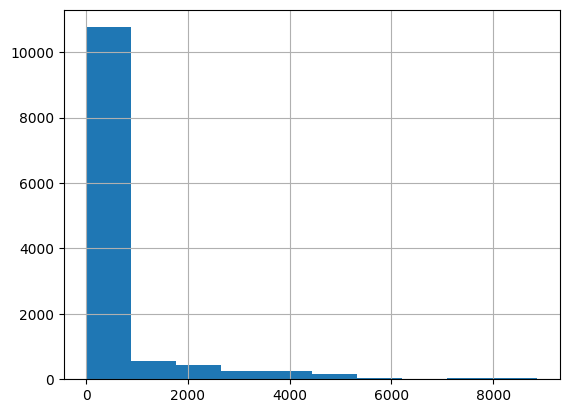

In [ ]:
hospedagens["qtnd_avaliacoes"].hist()

<Axes: >

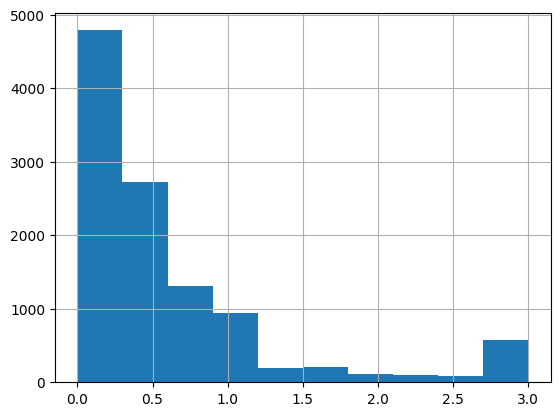

In [ ]:
hospedagens["dist_praia"].hist()

Todas as colunas analisadas são assimétricas e apresentam uma quantidade considerável de dados faltantes.

In [9]:
# gerando um novo dataset a partir do csv com os dados e transformando os dados categóricos em numérico
hosp_input = pd.read_csv('../resultado1.csv', decimal=".")
hosp_input['checkin'] = pd.to_datetime(hosp_input['checkin'])
hosp_input['mes_checkin'] = hosp_input['checkin'].dt.month
hosp_inputedagens = hosp_input[~((hosp_input['checkin'].dt.month > 6) & (hosp_input['checkin'].dt.year == 2025))]
hosp_input['checkin'] = hosp_input['checkin'].astype("category")
hosp_input['checkout'] = hosp_input['checkout'].astype("category")
hosp_input['cidade'] = hosp_input["cidade"].astype("category")
hosp_input['hotel'] = hosp_input["hotel"].astype("category")
hosp_input['data_extracao'] =hosp_input["data_extracao"].astype("category")
hosp_input['hotel'] = hosp_input['hotel'].cat.codes
hosp_input['checkin'] = hosp_input['checkin'].cat.codes
hosp_input['checkout'] = hosp_input['checkout'].cat.codes
hosp_input['cidade'] = hosp_input['cidade'].cat.codes
hosp_input['data_extracao'] = hosp_input['data_extracao'].cat.codes

In [ ]:
# entendendo a correlação dos dados a partir do método spearman (dados não simétricos)
hosp_input.corr(method="spearman")

,hotel,cidade,preço,checkin,checkout,dist_centro,dist_praia,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin
hotel,1.000000,NaN,-0.042618,-0.038618,-0.038614,-0.049422,0.071000,-0.137858,0.132421,NaN,0.016777
cidade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
preço,-0.042618,NaN,1.000000,0.044975,0.045242,0.117771,-0.174187,0.119423,0.059913,NaN,-0.046750
checkin,-0.038618,NaN,0.044975,1.000000,0.990569,-0.011076,0.025473,0.028097,-0.099139,NaN,-0.304321
checkout,-0.038614,NaN,0.045242,0.990569,1.000000,-0.010688,0.025448,0.027424,-0.098397,NaN,-0.304321
dist_centro,-0.049422,NaN,0.117771,-0.011076,-0.010688,1.000000,-0.207954,-0.048533,0.152088,NaN,0.009344
dist_praia,0.071000,NaN,-0.174187,0.025473,0.025448,-0.207954,1.000000,-0.058528,-0.223552,NaN,-0.020492
avaliacao,-0.137858,NaN,0.119423,0.028097,0.027424,-0.048533,-0.058528,1.000000,-0.216860,NaN,-0.009371
qtnd_avaliacoes,0.132421,NaN,0.059913,-0.099139,-0.098397,0.152088,-0.223552,-0.216860,1.000000,NaN,0.053884
data_extracao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Algumas correlações entre varáveis parecem importantes, então vamos normalizar os dados para utilizar o KNN para imputação.

In [ ]:
# normalizando os dados
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['preço', 'dist_centro', 'dist_praia', 'avaliacao', 'qtnd_avaliacoes']
scaler = MinMaxScaler()

hosp_input[columns_to_normalize] = scaler.fit_transform(hosp_input[columns_to_normalize])

print(hosp_input)

       hotel  cidade     preço  checkin  checkout  dist_centro  dist_praia  \
0        476       0  0.074051        0         3     0.088565    0.166667   
1        496       0  0.067001        0         3     0.050448    0.083333   
2        699       0  0.009822        0         3     0.000000    0.833333   
3         15       0  0.038168        0         3     0.011211         NaN   
4        695       0  0.074148        0         3     0.076233    0.216667   
...      ...     ...       ...      ...       ...          ...         ...   
16900    410       0  0.209899       54        53     0.048206    0.066667   
16901    459       0  0.126854       54        53     0.098655    0.300000   
16902    527       0  0.131716       54        53     0.183857    0.166667   
16903     20       0  0.185054       54        53     0.091928         NaN   
16904    216       0  0.785433       54        53     0.060538         NaN   

       avaliacao  qtnd_avaliacoes  data_extracao  mes_checkin  

In [ ]:
# rodando o KNN impute para imputar os dados faltantes
from fancyimpute import KNN
hosp_knn = KNN(k=3).fit_transform(hosp_input)

Imputing row 1/16905 with 0 missing, elapsed time: 196.546
Imputing row 101/16905 with 0 missing, elapsed time: 196.763
Imputing row 201/16905 with 0 missing, elapsed time: 196.840
Imputing row 301/16905 with 0 missing, elapsed time: 196.963
Imputing row 401/16905 with 0 missing, elapsed time: 197.209
Imputing row 501/16905 with 0 missing, elapsed time: 197.611
Imputing row 601/16905 with 1 missing, elapsed time: 197.691
Imputing row 701/16905 with 0 missing, elapsed time: 197.807
Imputing row 801/16905 with 0 missing, elapsed time: 197.940
Imputing row 901/16905 with 3 missing, elapsed time: 198.088
Imputing row 1001/16905 with 0 missing, elapsed time: 198.421
Imputing row 1101/16905 with 0 missing, elapsed time: 198.862
Imputing row 1201/16905 with 0 missing, elapsed time: 199.024
Imputing row 1301/16905 with 0 missing, elapsed time: 199.244
Imputing row 1401/16905 with 0 missing, elapsed time: 199.423
Imputing row 1501/16905 with 0 missing, elapsed time: 199.617
Imputing row 1601/16

In [ ]:
hosp2 = pd.DataFrame(data=hosp_knn[0:,0:],columns=['hotel', 'cidade', 'preço', 'checkin', 'checkout', 'dist_centro', 'dist_praia','avaliacao', 'qtnd_avaliacoes', 'data_extracao', 'mes_checkin'])

In [ ]:
# revertendo a normalização
hosp2[columns_to_normalize] = scaler.inverse_transform(hosp2[columns_to_normalize])

In [ ]:
hosp2.corr(method='spearman')

,hotel,cidade,preço,checkin,checkout,dist_centro,dist_praia,avaliacao,qtnd_avaliacoes,data_extracao,mes_checkin
hotel,1.000000,NaN,-0.042618,-0.038618,-0.038614,-0.049422,0.059833,-0.158692,0.151086,NaN,0.016777
cidade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
preço,-0.042618,NaN,1.000000,0.044975,0.045242,0.117771,-0.127204,0.109818,0.044803,NaN,-0.046750
checkin,-0.038618,NaN,0.044975,1.000000,0.990569,-0.011076,0.005321,0.035479,-0.126917,NaN,-0.304321
checkout,-0.038614,NaN,0.045242,0.990569,1.000000,-0.010688,0.006009,0.034054,-0.125264,NaN,-0.304321
dist_centro,-0.049422,NaN,0.117771,-0.011076,-0.010688,1.000000,-0.171829,-0.032356,0.114594,NaN,0.009344
dist_praia,0.059833,NaN,-0.127204,0.005321,0.006009,-0.171829,1.000000,-0.043293,-0.158911,NaN,-0.016276
avaliacao,-0.158692,NaN,0.109818,0.035479,0.034054,-0.032356,-0.043293,1.000000,-0.229742,NaN,-0.008352
qtnd_avaliacoes,0.151086,NaN,0.044803,-0.126917,-0.125264,0.114594,-0.158911,-0.229742,1.000000,NaN,0.059890
data_extracao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# mediana antiga
hosp_input[columns_to_normalize] = scaler.inverse_transform(hosp2[columns_to_normalize])
hosp_input.median()

hotel              3.810000e+02
cidade             0.000000e+00
preço              3.352444e+07
checkin            1.700000e+01
checkout           1.700000e+01
dist_centro        6.067600e+02
dist_praia         1.215788e+00
avaliacao          7.930000e+01
qtnd_avaliacoes    1.063210e+05
data_extracao      0.000000e+00
mes_checkin        8.000000e+00
dtype: float64

In [ ]:
#nova mediana
hosp2.median()

hotel               381.000000
cidade                0.000000
preço              1630.000000
checkin              17.000000
checkout             17.000000
dist_centro           6.800000
dist_praia            0.405263
avaliacao             8.700000
qtnd_avaliacoes      12.000000
data_extracao         0.000000
mes_checkin           8.000000
dtype: float64

## Outliers


Como nosso objetivo é analisar principalmente o preço das hospedagens, vamos focar na remoção de outliers sobre a coluna preço

C:\Users\extre\AppData\Local\Temp\ipykernel_7744\809166094.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospedagens['log_price'] = hospedagens['preço'].apply(np.log10)


<Axes: >

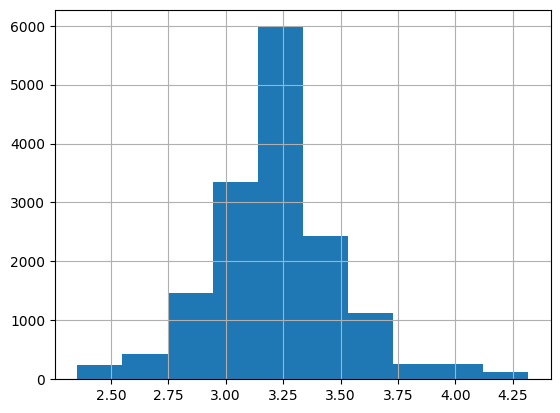

In [12]:
# plotando um histograma com valores normalizados do preço
# como vimos em cima, os dados são assimétricos e é necessário a aplicação do log10 sobre o preço
hospedagens['log_price'] = hospedagens['preço'].apply(np.log10)
hospedagens[hospedagens['log_price'] > 0]['log_price'].hist()

<Axes: >

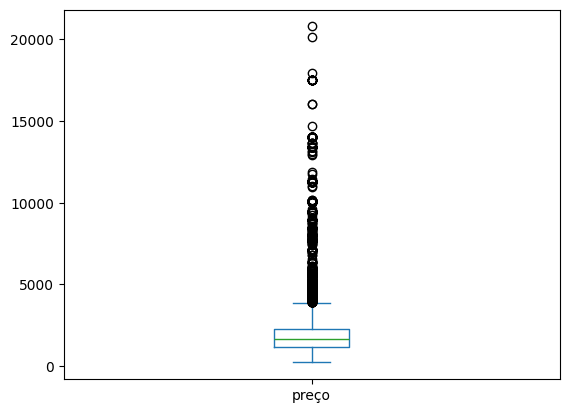

In [14]:
hospedagens[['preço']].plot(kind='box')


In [16]:
hospedagens.dtypes

hotel                    category
cidade                   category
preço                       int64
checkin            datetime64[ns]
checkout           datetime64[ns]
dist_centro               float64
dist_praia                float64
avaliacao                 float64
qtnd_avaliacoes           float64
data_extracao            category
log_price                 float64
dtype: object

Como podemos ver no boxplot, existem uma considerável quantidade de outliers em vários meses do nosso dataset. Como queremos entender as variabilidades do preço durante os meses, se tornou interessante a alternativa de remover os outliers por meses ao invés de remover pelo dataset inteiro.

In [18]:
# calculando o iqr por mês dos preços em log10
grouped = hospedagens.groupby('mes_checkin')['log_price']

q1_per_month = grouped.quantile(0.25)
q3_per_month = grouped.quantile(0.75)

iqr_per_month = q3_per_month - q1_per_month

print('iqr: ', iqr_per_month)

iqr:  mes_checkin
1     0.307016
2     0.343546
3     0.411842
4     0.376068
5     0.369050
6     0.393092
7     0.238398
8     0.235193
9     0.244503
10    0.247602
11    0.249763
12    0.282745
Name: log_price, dtype: float64


In [19]:
# Aplicar a condição de Tukey ajustada diretamente ao DataFrame original
# Remove os outliers por mês de acordo com seu IQR
hospedagens_clean = hospedagens.groupby('mes_checkin').apply(lambda x: x[
    (x['log_price'] >= (q1_per_month[x.name] - 1.5 * iqr_per_month[x.name])) &
    (x['log_price'] <= (q3_per_month[x.name] + 1.5 * iqr_per_month[x.name]))
]).reset_index(drop=True)

C:\Users\extre\AppData\Local\Temp\ipykernel_7744\1487978861.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hospedagens_clean = hospedagens.groupby('mes_checkin').apply(lambda x: x[


In [20]:
# dataset após a remoção
hospedagens_clean

,hotel,cidade,preço,checkin,checkout,dist_centro,dist_praia,avaliacao,qtnd_avaliacoes,data_extracao,log_price,mes_checkin
0,Villa d'Oro Hotel,Recife,1389,2025-01-01,2025-01-08,1.4,2.9,8.6,1620.0,2024-6-6,3.142702,1
1,Hotel Central,Recife,805,2025-01-01,2025-01-08,0.8,NaN,7.3,393.0,2024-6-6,2.905796,1
2,APARTAMENTO PROXIMO À UFPE,Recife,964,2025-01-01,2025-01-08,8.4,NaN,9.1,14.0,2024-6-6,2.984077,1
3,Lindo APT Cinza à 50m do mar - Praia de Boa Vi...,Recife,1017,2025-01-01,2025-01-08,5.8,NaN,10.0,1.0,2024-6-6,3.007321,1
4,Lar Recife Olinda - Hostel com suites individuais,Recife,1091,2025-01-01,2025-01-08,3.5,1.6,9.5,105.0,2024-6-6,3.037825,1
...,...,...,...,...,...,...,...,...,...,...,...,...
14684,Apto a beira-mar em Jaboatao dos Guararapes PE,Recife,4128,2024-12-22,2024-12-29,19.4,0.6,9.0,2.0,2024-6-6,3.615740,12
14685,Hostel da Socorro,Recife,2835,2024-12-22,2024-12-29,9.0,0.9,1.0,1.0,2024-6-6,3.452553,12
14686,Flat Equipado-Jaqueira Otima Localização-SH032,Recife,4544,2024-12-22,2024-12-29,3.0,NaN,8.2,6.0,2024-6-6,3.657438,12
14687,Lindo apto à beira-mar Jaboatão dos Guararapes...,Recife,5514,2024-12-22,2024-12-29,16.6,0.5,7.0,1.0,2024-6-6,3.741467,12


In [21]:
# média nova dos preços de cada mês
preco_medio_mensal = hospedagens_clean.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].mean()
preco_medio_mensal

C:\Users\extre\AppData\Local\Temp\ipykernel_7744\139006889.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  preco_medio_mensal = hospedagens_clean.groupby(pd.Grouper(key='checkin', freq="M"))['preço'].mean()


checkin
2024-07-31    1715.769387
2024-08-31    1645.414099
2024-09-30    1720.720195
2024-10-31    1762.274056
2024-11-30    1806.231776
2024-12-31    2015.132750
2025-01-31    2128.298424
2025-02-28    2015.024709
2025-03-31    2683.467026
2025-04-30    2102.872283
2025-05-31    2018.750000
2025-06-30    1873.267507
Freq: ME, Name: preço, dtype: float64

<Axes: >

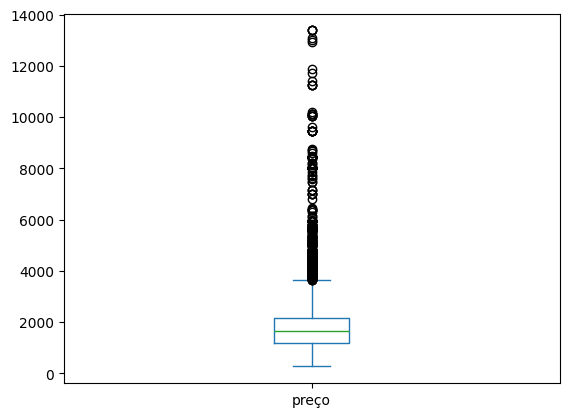

In [26]:
hospedagens_clean['preço'].plot(kind='box')

<Axes: xlabel='dist_praia', ylabel='preço'>

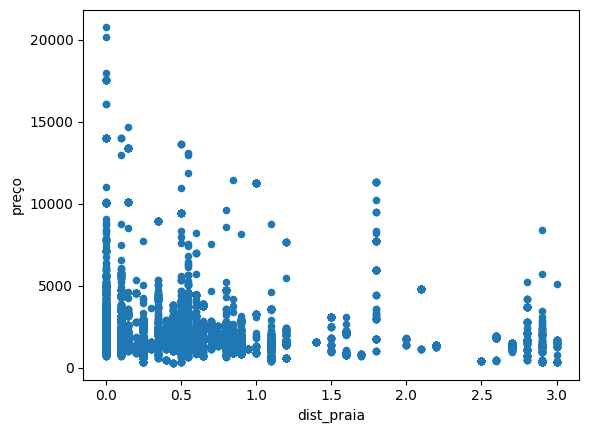

In [30]:
hospedagens.plot.scatter(x='dist_praia',y='preço')

## Discretização

In [51]:
# Discretizar a coluna de preços em 5 categorias
hospedagens_clean['price_category'] = pd.qcut(hospedagens_clean['preço'], 5, labels=['Econômico', 'Baixo', 'Médio', 'Caro', 'Muito Caro'])


In [52]:
hospedagens_clean.head()

,hotel,cidade,preço,checkin,checkout,dist_centro,dist_praia,avaliacao,qtnd_avaliacoes,data_extracao,log_price,mes_checkin,price_category
0,Villa d'Oro Hotel,Recife,1389,2025-01-01,2025-01-08,1.4,2.9,8.6,1620.0,2024-6-6,3.142702,1,Baixo
1,Hotel Central,Recife,805,2025-01-01,2025-01-08,0.8,NaN,7.3,393.0,2024-6-6,2.905796,1,De graça
2,APARTAMENTO PROXIMO À UFPE,Recife,964,2025-01-01,2025-01-08,8.4,NaN,9.1,14.0,2024-6-6,2.984077,1,De graça
3,Lindo APT Cinza à 50m do mar - Praia de Boa Vi...,Recife,1017,2025-01-01,2025-01-08,5.8,NaN,10.0,1.0,2024-6-6,3.007321,1,De graça
4,Lar Recife Olinda - Hostel com suites individuais,Recife,1091,2025-01-01,2025-01-08,3.5,1.6,9.5,105.0,2024-6-6,3.037825,1,De graça


In [54]:
# Definir a função para mapear os meses para as estações do ano
def month_to_season(month):
    if month in [9, 10, 11]:
        return 'Primavera'
    elif month in [12, 1, 2]:
        return 'Verão'
    elif month in [3, 4, 5]:
        return 'Outono'
    else:
        return 'Inverno'

# Discretizar os meses e adicionar categorias de estações do ano
hospedagens_clean['season'] = hospedagens_clean['mes_checkin'].apply(month_to_season)
hospedagens_clean.head(10)

,hotel,cidade,preço,checkin,checkout,dist_centro,dist_praia,avaliacao,qtnd_avaliacoes,data_extracao,log_price,mes_checkin,price_category,season
0,Villa d'Oro Hotel,Recife,1389,2025-01-01,2025-01-08,1.4,2.90,8.6,1620.0,2024-6-6,3.142702,1,Baixo,Verão
1,Hotel Central,Recife,805,2025-01-01,2025-01-08,0.8,NaN,7.3,393.0,2024-6-6,2.905796,1,De graça,Verão
2,APARTAMENTO PROXIMO À UFPE,Recife,964,2025-01-01,2025-01-08,8.4,NaN,9.1,14.0,2024-6-6,2.984077,1,De graça,Verão
3,Lindo APT Cinza à 50m do mar - Praia de Boa Vi...,Recife,1017,2025-01-01,2025-01-08,5.8,NaN,10.0,1.0,2024-6-6,3.007321,1,De graça,Verão
4,Lar Recife Olinda - Hostel com suites individuais,Recife,1091,2025-01-01,2025-01-08,3.5,1.60,9.5,105.0,2024-6-6,3.037825,1,De graça,Verão
5,Bonito é ser Feliz,Recife,684,2025-01-01,2025-01-08,4.8,NaN,9.8,46.0,2024-6-6,2.835056,1,De graça,Verão
6,Park Hotel,Recife,2684,2025-01-01,2025-01-08,8.6,0.10,8.5,5064.0,2024-6-6,3.428783,1,Muito alto,Verão
7,Rede Andrade LG Inn,Recife,1827,2025-01-01,2025-01-08,6.8,0.25,7.7,8861.0,2024-6-6,3.261739,1,Alto,Verão
8,Qto Duplo próximo ao Shopping Recife,Recife,625,2025-01-01,2025-01-08,8.1,NaN,10.0,3.0,2024-6-6,2.795880,1,De graça,Verão
9,Hotel Pousada Casa Grande,Recife,1190,2025-01-01,2025-01-08,11.5,NaN,8.0,2.0,2024-6-6,3.075547,1,Baixo,Verão


In [57]:
hospedagens_clean[hospedagens_clean['mes_checkin'] == 12].head()

,hotel,cidade,preço,checkin,checkout,dist_centro,dist_praia,avaliacao,qtnd_avaliacoes,data_extracao,log_price,mes_checkin,price_category,season
13431,Hotel Golden Park Recife Boa Viagem,Recife,1722,2024-12-01,2024-12-08,9.3,0.00,7.5,2655.0,2024-6-6,3.236033,12,Médio,Verão
13432,Transamerica Fit Recife,Recife,1648,2024-12-01,2024-12-08,7.0,0.65,8.3,5177.0,2024-6-6,3.216957,12,Médio,Verão
13433,Aconchegante Apto de 1qt a 60mts do Consulado EUA,Recife,1011,2024-12-01,2024-12-08,1.2,NaN,9.7,36.0,2024-6-6,3.004751,12,De graça,Verão
13434,Park Hotel,Recife,2095,2024-12-01,2024-12-08,8.6,0.10,8.5,5064.0,2024-6-6,3.321184,12,Alto,Verão
13435,Hotel Central,Recife,805,2024-12-01,2024-12-08,0.8,NaN,7.3,393.0,2024-6-6,2.905796,12,De graça,Verão


In [63]:
hospedagens_clean[hospedagens_clean['price_category'] == 'Baixo']

,hotel,cidade,preço,checkin,checkout,dist_centro,dist_praia,avaliacao,qtnd_avaliacoes,data_extracao,log_price,mes_checkin,price_category,season
0,Villa d'Oro Hotel,Recife,1389,2025-01-01,2025-01-08,1.4,2.90,8.6,1620.0,2024-6-6,3.142702,1,Baixo,Verão
9,Hotel Pousada Casa Grande,Recife,1190,2025-01-01,2025-01-08,11.5,NaN,8.0,2.0,2024-6-6,3.075547,1,Baixo,Verão
25,ibis budget Recife Jaboatão,Recife,1265,2025-01-01,2025-01-08,12.7,0.00,8.4,2077.0,2024-6-6,3.102091,1,Baixo,Verão
34,Pousada Nordestina,Recife,1260,2025-01-01,2025-01-08,14.1,0.20,7.3,253.0,2024-6-6,3.100371,1,Baixo,Verão
46,Espaço inteiro a beira mar,Recife,1428,2025-01-01,2025-01-08,7.0,NaN,NaN,NaN,2024-6-6,3.154728,1,Baixo,Verão
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14618,Pousada Shalom,Recife,1190,2024-12-22,2024-12-29,4.8,NaN,NaN,NaN,2024-6-6,3.075547,12,Baixo,Verão
14619,Aurora Recife Hostel,Recife,1176,2024-12-22,2024-12-29,1.1,NaN,NaN,NaN,2024-6-6,3.070407,12,Baixo,Verão
14634,Quarto Litoral Sul,Recife,1418,2024-12-22,2024-12-29,4.5,0.15,1.0,1.0,2024-6-6,3.151676,12,Baixo,Verão
14661,Bugan Paiva flatpaivahome,Recife,1386,2024-12-22,2024-12-29,19.6,0.75,8.0,5.0,2024-6-6,3.141763,12,Baixo,Verão
